## 2023 La Nina Cruise ADCP transect plts and cleanup<br>
This notebook shows zonal and meridional velocity component graphs for the 2023 La Nina Cruise. The goal is to take a look at the data and get it ready for calculating mixing metrics<br>
Note that this notebook utilizes code from Susan Hautala and code inspired by ChatGPT

In [8]:
# Dependencies
import matplotlib.pyplot as plt
import matplotlib as mpl


import numpy as np
import pandas as pd
import xarray as xr
import math
import gsw

import mixsea as mx

In [9]:
mpl.rcParams.update({
    'font.size': 14,           # Default font size
    'axes.labelsize': 14,      # Font size for axis labels
    'axes.titlesize': 16,      # Font size for titles
    'xtick.labelsize': 12,     # Font size for x-axis ticks
    'ytick.labelsize': 12,     # Font size for y-axis ticks
    'legend.fontsize': 12,     # Font size for legend
    'figure.titlesize': 18     # Font size for figure titles
})

In [10]:
# Load ADCP Data
datadir = 'data/2023/adcp' 
filepathadcp = datadir+'/os75nb.nc' # filepath
ADCP_all = xr.open_dataset(filepathadcp, decode_times=False) # open dataset

Let's extract our data from the dataset and remove large NaN gaps that came from os75nb depth limits and masking stationary ADCP data that arise during CTD casts

In [11]:
# this function removes large NaN rows below selected data. i.e., where data gets bad due to os75nb depth limits
def drop_past_dbin(input_data, depth_bin):
    return input_data[:depth_bin] # remove past a selected depth bin

# this function removes large NaN columns that exist throughout all depth bins, handling gaps in data that
# come from when the ship was stationary for CTD casts. i.e., where the ADCP measured the same waters continuously.
def drop_whole_column(input_data):
    mask = np.isnan(input_data)
    cols_to_delete = np.all(mask, axis=0) & (input_data.shape[0] == 46)
    return input_data[:, ~cols_to_delete]

In [12]:
ADCP = ADCP_all.sel(time=slice(62.08, 65.65)) # entire time slice from 5S to 5Nt
v = drop_whole_column(drop_past_dbin(np.array((ADCP['v'].where(ADCP['pflag'] == 0))).T, 46)) # select meridional
u = drop_whole_column(drop_past_dbin(np.array((ADCP['u'].where(ADCP['pflag'] == 0))).T, 46)) # select zonal

lat = np.array(ADCP['lat'].values) # select lats
lat = np.linspace(np.min(lat), np.max(lat), len(v.T)) # ensure lats are in the right shape for use as contourf input
# this is fine because v and u depth bins are also linearly spaced

z = drop_past_dbin(np.array((ADCP['depth'].values)).T, 46) # select depths
z = (z.T[:len(v.T)]).T # as depths are the same across rows, we can set n cols = n cols in v
z = np.linspace(np.min(z), math.ceil(np.max(z) / 10.0) * 10, len(z)) # ensure z is the right shape 
# for use as contourf input. this is fine because v and u depth bins are also linearly spaced 
# note that the math.ceil function is used to round 748.9 to 750 for ease of compatability with CTD casts

In [13]:
max_rounded = math.ceil(np.max(z) / 10.0) * 10
max_rounded

750

In [26]:
np.shape(v)

(46, 630)

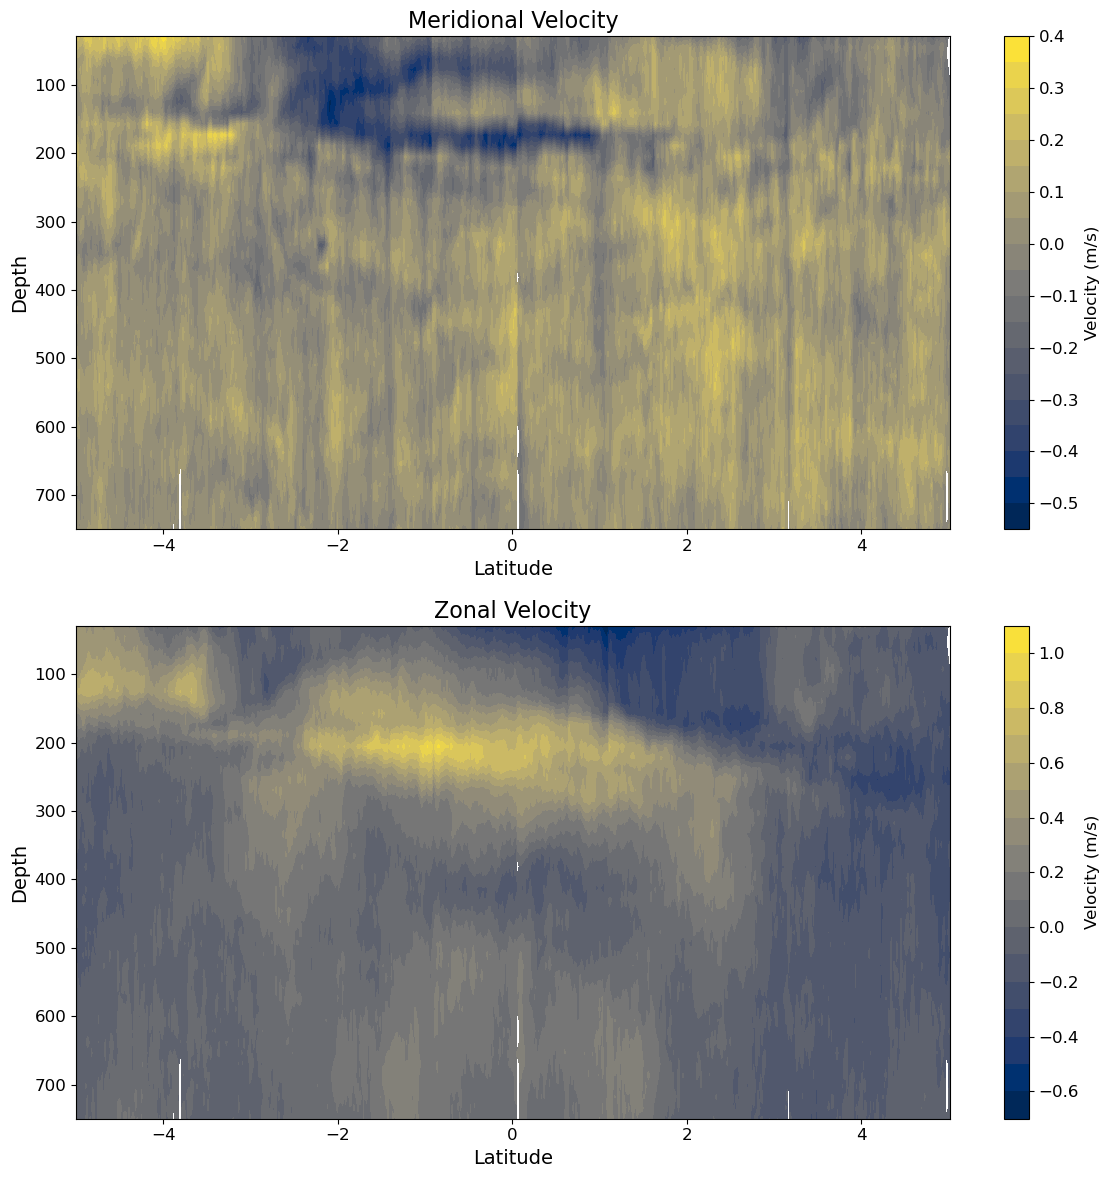

In [15]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# meridional velocity
contour1 = ax1.contourf(lat, z, v, levels=20, cmap='cividis')
ax1.set_xlabel('Latitude')
ax1.set_ylabel('Depth')
colorbar1 = plt.colorbar(contour1, ax=ax1)
colorbar1.set_label('Velocity (m/s)', fontsize=12)
ax1.set_title('Meridional Velocity')
ax1.invert_yaxis()

# zonal
contour2 = ax2.contourf(lat, z, u, levels=20, cmap='cividis')
ax2.set_xlabel('Latitude')
ax2.set_ylabel('Depth')
colorbar2 = plt.colorbar(contour2, ax=ax2)
colorbar2.set_label('Velocity (m/s)', fontsize=12)
ax2.set_title('Zonal Velocity')
ax2.invert_yaxis()

plt.tight_layout()

Let's save the cleaned ADCP data as a netcdf file

In [17]:
data = {
    'u': xr.DataArray(u, dims=('time', 'depth_cell')),  # Assuming u has dimensions (time, depth)
    'v': xr.DataArray(v, dims=('time', 'depth_cell')),  # Assuming v has dimensions (time, depth)
    'z': xr.DataArray(z, dims=('time',)),  # Assuming z has dimensions (time, depth)
    'lat': xr.DataArray(lat, dims=('depth_cell',))  # Assuming lat has dimension (time,)
}
uvz_lat = xr.Dataset(data)

# Save the Dataset to a NetCDF file
#uvz_lat.to_netcdf('data/2023/adcp/os75nb_cleaned.nc')

In [24]:
(data['u'])

<xarray.DataArray (time: 46, depth_cell: 630)>
array([[ 0.43006635,  0.41242668,  0.39314455, ..., -0.08724093,
        -0.12294322,         nan],
       [ 0.4750663 ,  0.44142666,  0.45814455, ..., -0.12524094,
                nan,         nan],
       [ 0.4520663 ,  0.46242666,  0.48314452, ..., -0.12624094,
                nan,         nan],
       ...,
       [-0.04393369, -0.04557335, -0.06085548, ...,         nan,
        -0.10394323, -0.07091521],
       [-0.04693371, -0.03057335, -0.01885548, ...,         nan,
        -0.07994322, -0.0669152 ],
       [-0.0569337 , -0.03557335, -0.03385548, ..., -0.06024094,
        -0.07394323, -0.04091519]], dtype=float32)
Dimensions without coordinates: time, depth_cell